# SediNet: compute grain size percentiles, 'global' dataset

In [30]:
%matplotlib inline
from matplotlib.backends.backend_agg import FigureCanvas
from matplotlib.figure import Figure

from file_select import FileBrowser
from PIL import Image
import random
import hvplot.pandas
from holoviews import opts

In [2]:
import sys
#sys.path.append('../')
from sedinet_models import *
import panel as pn
pn.extension()

Using TensorFlow backend.


In [3]:
configfile = 'config_9percentiles.json'

In [4]:
import json
# load the user configs
with open('config'+os.sep+configfile) as f:    
  config = json.load(f) 

###===================================================
## user defined variables: proportion of data to use for training (a.k.a. the "train/test split")
base    = int(config["base"]) #minimum number of convolutions in a sedinet convolutional block
csvfile = config["csvfile"] #csvfile containing image names and class values
res_folder = config["res_folder"] #folder containing csv file and that will contain model outputs
name = config["name"] #name prefix for output files
dropout = float(config["dropout"]) 
add_bn = bool(config["add_bn"]) 

vars = [k for k in config.keys() if not np.any([k.startswith('base'), k.startswith('res_folder'), k.startswith('csvfile'), k.startswith('name'), k.startswith('dropout'), k.startswith('add_bn')])]

vars = sorted(vars)

###==================================================

csvfile = os.path.abspath(os.getcwd()+os.sep+res_folder+os.sep+csvfile)

In [5]:
## read the data set in, clean and modify the pathnames so they are absolute
df = pd.read_csv(csvfile)
df['files'] = [k.strip() for k in df['files']]
df['files'] = [os.getcwd()+os.sep+f.replace('\\',os.sep) for f in df['files']]    

In [6]:
models = []
for base in [base-2,base,base+2]:
  weights_path = name+"_base"+str(base)+"_model_checkpoint.hdf5"
  ##==============================================
  ## create a SediNet model to estimate sediment category
  model = make_cont_sedinet(base, vars, add_bn, dropout)
  model.load_weights(os.getcwd()+os.sep+'res'+os.sep+res_folder+os.sep+weights_path)
  models.append(model)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
[INFORMATION] Model summary:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 1024, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 510, 1022, 14 140         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 508, 1020, 28 3556        conv2d_1[0][0]                   
___________________________________________________________________________________________

[INFORMATION] Model summary:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 512, 1024, 1) 0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 510, 1022, 18 180         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 508, 1020, 36 5868        conv2d_9[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 254, 510, 36) 0           conv2d_10[0][0]                  
________________________________________________________________________________

In [7]:
import param
from bokeh.plotting import figure

In [50]:
#initiate with dummy data
data = pd.DataFrame({})       
data['vals']=np.asarray([5,5,10,20,40,80,160,320,480])    

Row
    [0] Column
        [0] HTML(str)
        [1] JPG(str, width=60)
        [2] HTML(str)
        [3] Row
            [0] Select(options=['C:\\Users\\ddb265\\SediN...], value='C:\\Users\\ddb265\\SediNe...)
        [4] Row
            [0] Button(button_type='primary', name='Calculate Grain Size!', width=100)
        [5] JPG(str, width=300)
        [6] Markdown(str, height=60, sizing_mode='fixed', width=200)
        [7] Markdown(str, height=60, sizing_mode='fixed', width=200)
        [8] HTML(str)
    [1] Tabs
        [0] Bokeh(Figure, name='GSD')
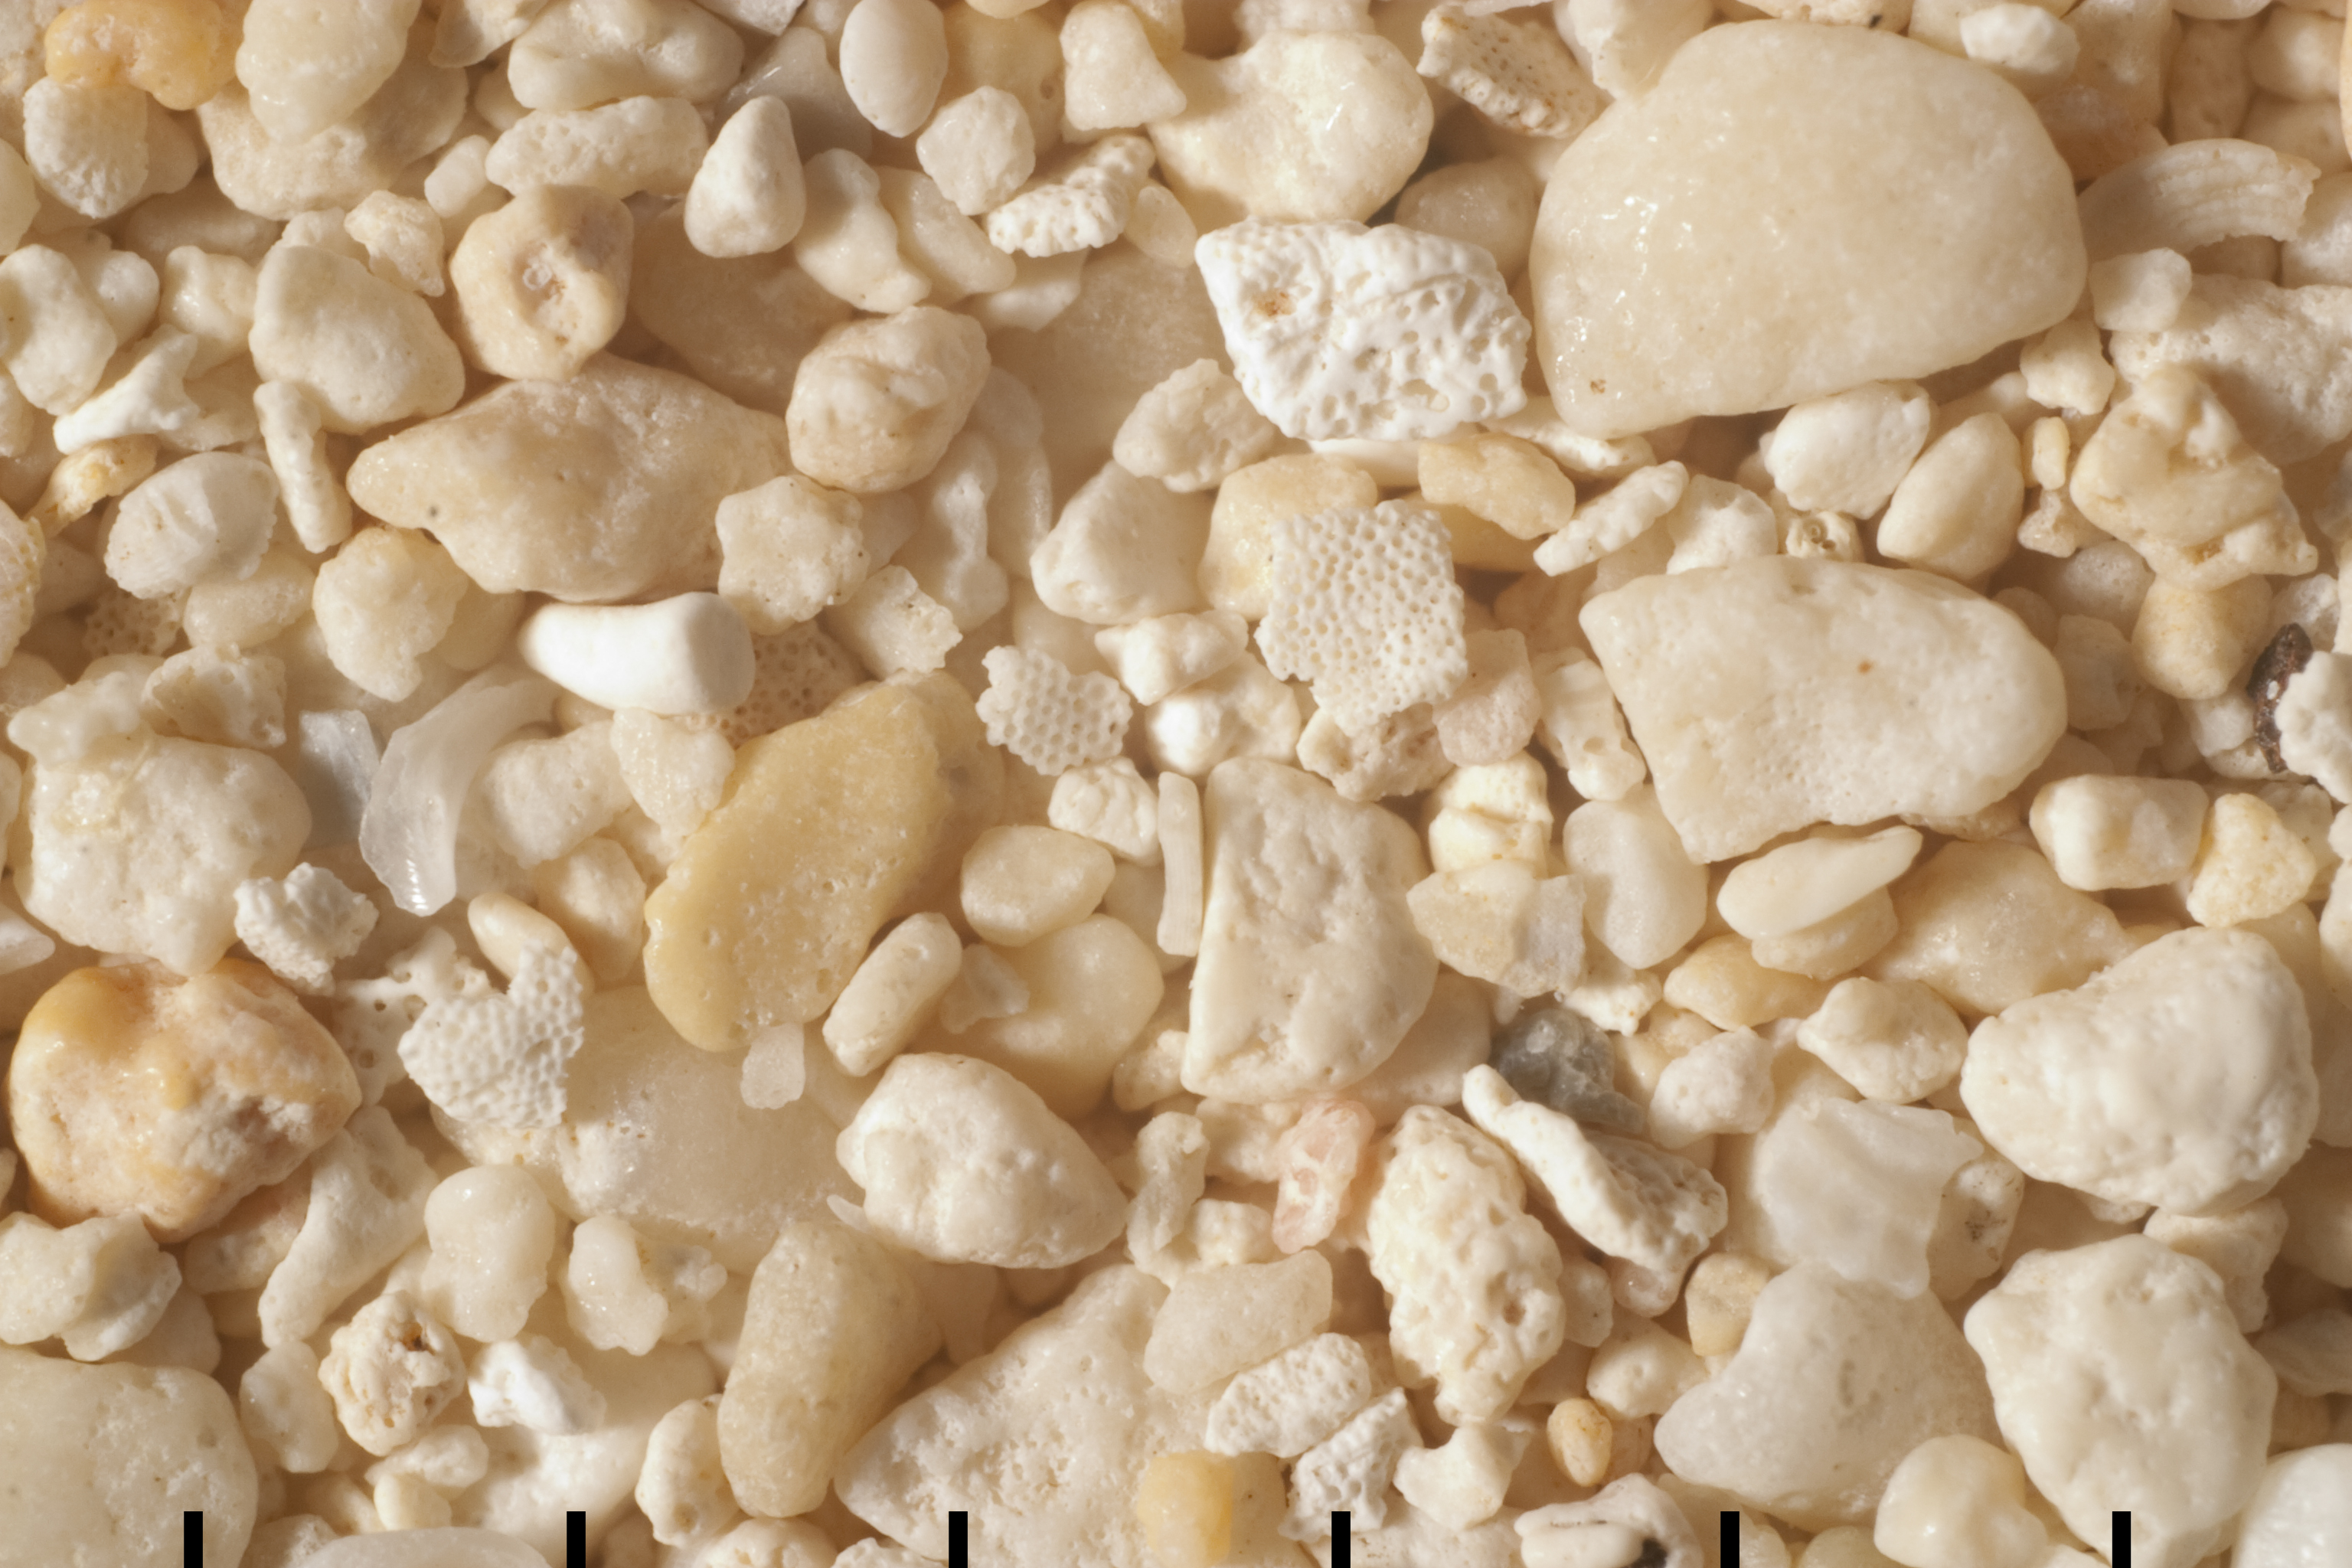
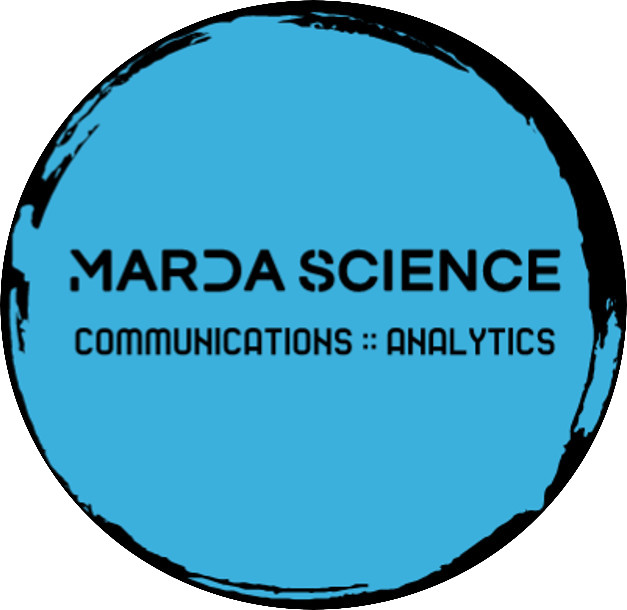

In [49]:
from bokeh.plotting import figure

def get_image():
    #get a random image
    n = random.choice((67364561,67447491,67449081,59858041,94974311,65614911))
    img = 'https://www.allaboutbirds.org/guide/assets/photo/{n}-1280px.jpg'.format(n=n)
    return img

def get_grainsize():
    im = Image.open(file_input.value).convert('LA')
    im = im.resize((IM_HEIGHT, IM_HEIGHT))
    im = np.array(im) / 255.0    
    im2 = np.rot90(im)         
    im = np.expand_dims(np.hstack((im[:,:,0], im2[:,:,0])),axis=2) 
    im = np.expand_dims(im, axis=0)

    for v in vars:
       exec(v+'_PT = []')
         
    for model in models:   
       tmp = model.predict(im, batch_size=1)   
       counter = 0
       for v in vars:
          exec(v+'_PT.append(np.squeeze(tmp[counter]))')
          counter +=1
          
    for k in range(len(vars)):  
       exec(vars[k]+'_predT = np.squeeze(np.mean(np.asarray('+vars[k]+'_PT), axis=0))')
              
    Text.object = '50th percentile: '+str(eval(vars[4]+'_predT'))+' pixels'
    
    vals = [eval(vars[0]+'_predT'),eval(vars[1]+'_predT'),eval(vars[2]+'_predT'),
           eval(vars[3]+'_predT'),eval(vars[4]+'_predT'),eval(vars[5]+'_predT'),
           eval(vars[6]+'_predT'),eval(vars[7]+'_predT'),eval(vars[8]+'_predT')]
    vals = sorted(vals)

    r = lambda: random.randint(0,255)
    col = '#%02X%02X%02X' % (r(),r(),r())
    p2.line(vals, [5,10,16,25,50,75,84,90,95],color=col)
    
    return Text, Text2, vals

def show_message():
    Text2.object = 'Calculated grain size for '+file_input.value +'.....'
    return Text2

def update(event):
    Text2 = show_message()
    jpg_panel.object = file_input.value 
    Text, Text2, vals = get_grainsize()

    
##=====  

title = pn.pane.HTML('<h2> SediNet: compute nine grain size percentiles</h2>')

imfile = 'MardaScience_logo_circle.JPG'
#setup the logo pane
logo = pn.pane.JPG(get_image(), width=60)
logo.object = imfile

update_btn = pn.widgets.Button(name='Calculate Grain Size!',width=100,button_type='primary')
s = pn.pane.HTML('<h5>Compute grain size in pixels. This demonstration has been implemented using a large population of sediment</h5>')
file_input = pn.widgets.FileInput()
file_input = pn.widgets.Select(name='Select an image file:', options=list(df.files.values))

Text = pn.panel('50th percentile: ', width=200, height=60)

Text2 = pn.panel('', width=200, height=60)
    
#setup the jpg pane
jpg_panel = pn.pane.JPG(get_image(), width=300)
jpg_panel.object = file_input.value 

footer = pn.pane.HTML('<h6>Demonstration of SediNet using Panel. Written by Daniel Buscombe, MARDA Science</h6>')

p2 = figure(width=300, height=300)
p2.line([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan], [5,10,16,25,50,75,84,90,95], color='black')

tabs = pn.Tabs(('GSD', p2))
tabs.clone(closable=True)

#watch associates a button click with the update function
update_btn.param.watch(update, 'clicks')
#add the widgets to panes
top = pn.Row(file_input) 
mid = pn.Row(update_btn)
app = pn.Row(pn.Column(title, logo, s, top,mid,jpg_panel, Text2, Text, footer), tabs)
app.servable()

'#47051A'